In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import prep, plots, params, feats, strategies
importlib.reload(prep)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)

<module 'libs.strategies' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strategies.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vol_spike_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,1.023843,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,0.576864,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,0.443475,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,0.311600,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,0.282936,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,0.331950,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,0.237621,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,0.269923,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,4.429807,147.712062


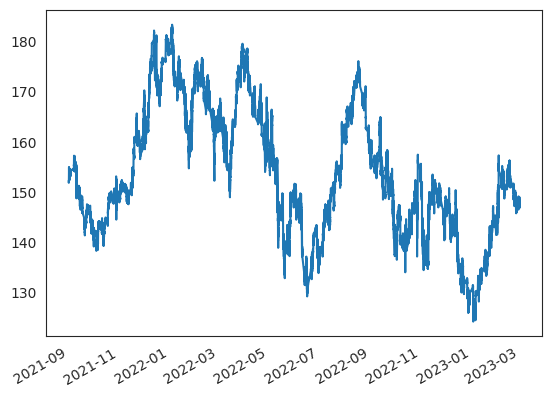

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_vol_spike_tick,
    params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
prun_perc       = 80
report_interval = 50

# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")


Baseline mean daily B&H: -9.5162


In [5]:
def objective(trial: optuna.Trial) -> float:
    # --- Signal params ---
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.1, 1.5)
    max_down_prop   = trial.suggest_float("max_down_prop", 0.05, 0.5)
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.0, 0.05)
    tau_time        = trial.suggest_float("tau_time", 30.0, 600.0, log=True)
    tau_dur         = trial.suggest_float("tau_dur", 30.0, 600.0, log=True)
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                       ["median_nonzero", "p90", "mean_nonzero", "roll_mean", "roll_p90"])
    thresh_window   = trial.suggest_int("thresh_window", 10, 120) if "roll" in thresh_mode else None

    # --- Trading params ---
    reset_peak     = trial.suggest_categorical("reset_peak", [True, False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 5, 65)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", rsi_min_thresh + 5, 98)
    vol_thresh     = trial.suggest_float("vol_thresh", 0.3, 6.0)
    adx_thresh     = trial.suggest_float("adx_thresh", 8.0, 45.0)
    atr_mult       = trial.suggest_float("atr_mult", 0.5, 8.0, log=True)
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -5.0, 5.0)
    buy_factor     = trial.suggest_float("buy_factor", 0.0, 1.0)
    sell_factor    = trial.suggest_float("sell_factor", 0.0, 1.0)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.2, 8.0)

    print("-" * 150)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = prep.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strategies.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strategies.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = params.sess_premark,
        )

        sim_results = strategies.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strategies._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strategies._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.4071564109573562; max_down_prop=0.4144343184628744; gain_tightfact=0.04941404825126147; tau_time=296.7440602211237; tau_dur=478.08110119086024; thresh_mode=median_nonzero; reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=40; vol_thresh=3.487352855607985; adx_thresh=13.307758061529896; atr_mult=2.6478146841710544; vwap_atr_mult=-3.36664774242689; buy_factor=0.46254872724326146; sell_factor=0.3313117110776155; trailstop_pct=7.540867305714916


/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
Trial 0: 100%|██████████| 375/375 [00:28<00:00, 13.08it/s]


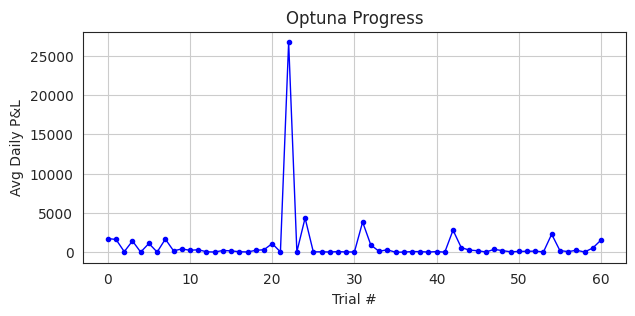

[Results] mean_pnl:1719.0613 mean_bh:-8.7491 mean_excess:1727.8104 improv_vs_bh:19748.46%
Action counts: {'Buy': 456, 'Sell': 2115, 'Hold': 348140}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.0829875519137908; max_down_prop=0.18947742607056034; gain_tightfact=0.026350707880190113; tau_time=165.66614064192458; tau_dur=148.06299004026476; thresh_mode=median_nonzero; reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=90; vol_thresh=0.5331976807512938; adx_thresh=20.835855943936895; atr_mult=1.4033786434562545; vwap_atr_mult=4.8950061115841415; buy_factor=0.6353856216903705; sell_factor=0.9713880916224552; trailstop_pct=4.925714055519834


Trial 1: 100%|██████████| 375/375 [00:21<00:00, 17.52it/s]


[Results] mean_pnl:1602.0999 mean_bh:-8.7491 mean_excess:1610.8490 improv_vs_bh:18411.62%
Action counts: {'Buy': 1575, 'Sell': 849, 'Hold': 348287}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.8873166777889143; max_down_prop=0.1639306466137867; gain_tightfact=0.0351836948658974; tau_time=78.43372054003088; tau_dur=37.90270003090107; thresh_mode=p90; reset_peak=True; rsi_min_thresh=47; rsi_max_thresh=91; vol_thresh=1.5121012253021209; adx_thresh=34.52055661146066; atr_mult=0.5544348050491978; vwap_atr_mult=-0.05999375096477433; buy_factor=0.47798753599660404; sell_factor=0.8977907460833073; trailstop_pct=5.36041042306885


Trial 2: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:48.7964 mean_bh:-8.7491 mean_excess:57.5455 improv_vs_bh:657.73%
Action counts: {'Buy': 64, 'Sell': 83, 'Hold': 350564}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2429522444363252; max_down_prop=0.28415175349410104; gain_tightfact=0.03319988369042362; tau_time=183.74143770385692; tau_dur=34.00724013920298; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=95; vol_thresh=1.3679959826181456; adx_thresh=31.644110215131644; atr_mult=0.6667048942075318; vwap_atr_mult=3.6908144212897405; buy_factor=0.23215222982126082; sell_factor=0.889314570722103; trailstop_pct=2.057682823698908


Trial 3: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1411.1304 mean_bh:-8.7491 mean_excess:1419.8795 improv_vs_bh:16228.88%
Action counts: {'Buy': 636, 'Sell': 648, 'Hold': 349427}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.15360423243636825; max_down_prop=0.19566716404100915; gain_tightfact=0.024942527096620565; tau_time=101.92680648169193; tau_dur=216.1444570689389; thresh_mode=roll_p90; thresh_window=64; reset_peak=True; rsi_min_thresh=50; rsi_max_thresh=81; vol_thresh=3.6461174861797945; adx_thresh=44.24943877554738; atr_mult=0.5139375646237168; vwap_atr_mult=3.583118301097876; buy_factor=0.9198254795984475; sell_factor=0.8032158119847314; trailstop_pct=3.5898776931070264


Trial 4: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:-5.3682 mean_bh:-8.7491 mean_excess:3.3809 improv_vs_bh:38.64%
Action counts: {'Buy': 19, 'Sell': 63, 'Hold': 350629}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.873653189969967; max_down_prop=0.22981405480181666; gain_tightfact=0.013113143033630975; tau_time=31.61766963592513; tau_dur=82.40556020344638; thresh_mode=roll_mean; thresh_window=46; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=66; vol_thresh=1.3756685052000568; adx_thresh=40.41874010899658; atr_mult=5.888668872479133; vwap_atr_mult=-3.5953692405213946; buy_factor=0.3967388581214303; sell_factor=0.6396224430567784; trailstop_pct=7.977859377402763


Trial 5: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:1097.5841 mean_bh:-8.7491 mean_excess:1106.3332 improv_vs_bh:12645.12%
Action counts: {'Buy': 758, 'Sell': 1176, 'Hold': 348777}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9947245028476713; max_down_prop=0.30166086688079957; gain_tightfact=0.010772206740061675; tau_time=167.5310830217007; tau_dur=65.59412594027302; thresh_mode=p90; reset_peak=True; rsi_min_thresh=55; rsi_max_thresh=86; vol_thresh=2.8811934099354914; adx_thresh=44.47424783368455; atr_mult=0.5053986552010765; vwap_atr_mult=3.8967835562480566; buy_factor=0.15988951697914922; sell_factor=0.6808037717701911; trailstop_pct=6.664830636098325


Trial 6: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:0.5910 mean_bh:-8.7491 mean_excess:9.3401 improv_vs_bh:106.76%
Action counts: {'Buy': 3, 'Sell': 10, 'Hold': 350698}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.3746334150966678; max_down_prop=0.42775151589849325; gain_tightfact=0.014425696576054671; tau_time=133.7851758124407; tau_dur=173.79920553634116; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=79; vol_thresh=3.886494608094791; adx_thresh=20.36580716790293; atr_mult=2.1796835378286756; vwap_atr_mult=4.041498428202544; buy_factor=0.10388057518495475; sell_factor=0.07299114378513039; trailstop_pct=3.132577678549961


Trial 7: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:1649.8745 mean_bh:-8.7491 mean_excess:1658.6236 improv_vs_bh:18957.67%
Action counts: {'Buy': 393, 'Sell': 2510, 'Hold': 347808}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.1718896048111274; max_down_prop=0.11684835584868226; gain_tightfact=0.03311474995756838; tau_time=115.86176243672733; tau_dur=73.40721917250195; thresh_mode=roll_mean; thresh_window=45; reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=91; vol_thresh=4.163280147639392; adx_thresh=23.80496884733546; atr_mult=1.2334698017519694; vwap_atr_mult=-4.464141418504983; buy_factor=0.5454216975413878; sell_factor=0.5953703657659434; trailstop_pct=4.28348693733008


Trial 8: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:152.4267 mean_bh:-8.7491 mean_excess:161.1758 improv_vs_bh:1842.20%
Action counts: {'Buy': 602, 'Sell': 2361, 'Hold': 347748}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.17195431323296553; max_down_prop=0.414838338531174; gain_tightfact=0.019654457030227137; tau_time=45.83330109287731; tau_dur=375.73240770607964; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=62; vol_thresh=3.2302833471719588; adx_thresh=20.15912103470616; atr_mult=1.2070203443585779; vwap_atr_mult=3.099093710609127; buy_factor=0.4908458632241728; sell_factor=0.33450022434952487; trailstop_pct=7.040906168401853


Trial 9: 100%|██████████| 375/375 [00:32<00:00, 11.47it/s]


[Results] mean_pnl:396.6882 mean_bh:-8.7491 mean_excess:405.4373 improv_vs_bh:4634.05%
Action counts: {'Buy': 244, 'Sell': 754, 'Hold': 349713}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9973955391726234; max_down_prop=0.4304894927898949; gain_tightfact=0.020150444667942427; tau_time=439.44905476830303; tau_dur=173.81390900050133; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=64; rsi_max_thresh=69; vol_thresh=2.242206804171824; adx_thresh=28.682189569032605; atr_mult=0.691470787951763; vwap_atr_mult=2.472783972105896; buy_factor=0.5203541262456729; sell_factor=0.9752423162228606; trailstop_pct=4.4304672050780445


Trial 10: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:223.5972 mean_bh:-8.7491 mean_excess:232.3463 improv_vs_bh:2655.66%
Action counts: {'Buy': 199, 'Sell': 216, 'Hold': 350296}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2939798729189016; max_down_prop=0.47101977799284356; gain_tightfact=0.042361190404086015; tau_time=52.086676157622875; tau_dur=128.47230384669504; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=98; vol_thresh=5.422192131062624; adx_thresh=20.702374024399425; atr_mult=1.2518800646132369; vwap_atr_mult=-3.5004864275388883; buy_factor=0.3584647952142491; sell_factor=0.5156900029893849; trailstop_pct=5.906246339476979


Trial 11: 100%|██████████| 375/375 [00:26<00:00, 14.12it/s]


[Results] mean_pnl:295.9113 mean_bh:-8.7491 mean_excess:304.6604 improv_vs_bh:3482.20%
Action counts: {'Buy': 92, 'Sell': 257, 'Hold': 350362}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.6473000922447578; max_down_prop=0.27898934585766283; gain_tightfact=0.009219876305551189; tau_time=109.50801176223958; tau_dur=46.06292007670753; thresh_mode=roll_p90; thresh_window=108; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=86; vol_thresh=4.478074152214533; adx_thresh=15.110209776121955; atr_mult=1.5389316061291294; vwap_atr_mult=-2.1589644121230167; buy_factor=0.5744312151473678; sell_factor=0.9574822150247663; trailstop_pct=2.922633047490239


Trial 12: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:33.6585 mean_bh:-8.7491 mean_excess:42.4076 improv_vs_bh:484.71%
Action counts: {'Buy': 455, 'Sell': 686, 'Hold': 349570}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.8937413149796666; max_down_prop=0.2602765956646375; gain_tightfact=0.036124306359293014; tau_time=386.00367667476166; tau_dur=111.38337698162385; thresh_mode=roll_mean; thresh_window=29; reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=26; vol_thresh=2.923703481254825; adx_thresh=26.578117580552966; atr_mult=3.2964557593941515; vwap_atr_mult=2.7271895255950938; buy_factor=0.5174585177587318; sell_factor=0.44882643449434634; trailstop_pct=2.475934019159919


Trial 13: 100%|██████████| 375/375 [00:21<00:00, 17.82it/s]


[Results] mean_pnl:3.4416 mean_bh:-8.7491 mean_excess:12.1907 improv_vs_bh:139.34%
Action counts: {'Buy': 158, 'Sell': 1068, 'Hold': 349485}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.23082922443642864; max_down_prop=0.06593912085207985; gain_tightfact=0.013134706923274536; tau_time=470.5506962078167; tau_dur=105.53414802557266; thresh_mode=roll_mean; thresh_window=107; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=14; vol_thresh=2.3257663488700024; adx_thresh=25.900071011487793; atr_mult=2.9567150075799287; vwap_atr_mult=-2.148290015358112; buy_factor=0.5901074007985652; sell_factor=0.8635395895859538; trailstop_pct=6.284482086300003


Trial 14: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:196.8695 mean_bh:-8.7491 mean_excess:205.6186 improv_vs_bh:2350.17%
Action counts: {'Buy': 1130, 'Sell': 2133, 'Hold': 347448}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.5653916981442672; max_down_prop=0.22028409609457317; gain_tightfact=0.0038025252215988016; tau_time=42.19882024871583; tau_dur=32.37000154364214; thresh_mode=roll_mean; thresh_window=88; reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=56; vol_thresh=4.934876767285801; adx_thresh=26.205556324445322; atr_mult=1.3334201162052217; vwap_atr_mult=4.973316999018774; buy_factor=0.32053049712662796; sell_factor=0.0525065457012025; trailstop_pct=3.44752390836194


Trial 15: 100%|██████████| 375/375 [00:21<00:00, 17.69it/s]


[Results] mean_pnl:153.1322 mean_bh:-8.7491 mean_excess:161.8813 improv_vs_bh:1850.26%
Action counts: {'Buy': 76, 'Sell': 477, 'Hold': 350158}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.8584593626143018; max_down_prop=0.218299116060434; gain_tightfact=0.014867358976011874; tau_time=256.4538081451128; tau_dur=314.1781890946662; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=64; rsi_max_thresh=71; vol_thresh=5.799872118410312; adx_thresh=11.762224751940796; atr_mult=2.055079403753522; vwap_atr_mult=4.201925967461197; buy_factor=0.6731111696438865; sell_factor=0.954484305158352; trailstop_pct=0.8404859368649222


Trial 16: 100%|██████████| 375/375 [00:18<00:00, 19.95it/s]


[Results] mean_pnl:35.8335 mean_bh:-8.7491 mean_excess:44.5826 improv_vs_bh:509.57%
Action counts: {'Buy': 16, 'Sell': 34, 'Hold': 350661}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2960070239428974; max_down_prop=0.06843514245468767; gain_tightfact=0.013149269503667899; tau_time=155.68668052622039; tau_dur=473.59121167907796; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=64; vol_thresh=3.2442384716584574; adx_thresh=43.009822452832864; atr_mult=7.082260715123586; vwap_atr_mult=-1.225414073999075; buy_factor=0.3778105481252818; sell_factor=0.8602188585289705; trailstop_pct=4.035745555463808


Trial 17: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:14.5391 mean_bh:-8.7491 mean_excess:23.2882 improv_vs_bh:266.18%
Action counts: {'Buy': 5, 'Sell': 7, 'Hold': 350699}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7623759895673929; max_down_prop=0.11694513374557275; gain_tightfact=0.014018575763710767; tau_time=44.8477471952573; tau_dur=246.0056837410012; thresh_mode=roll_mean; thresh_window=21; reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=88; vol_thresh=2.420210913979018; adx_thresh=12.101683242641803; atr_mult=2.3275893604932563; vwap_atr_mult=3.493238165973384; buy_factor=0.7052448681001454; sell_factor=0.5577889397354656; trailstop_pct=5.464047064368871


Trial 18: 100%|██████████| 375/375 [00:19<00:00, 19.19it/s]


[Results] mean_pnl:218.9380 mean_bh:-8.7491 mean_excess:227.6871 improv_vs_bh:2602.41%
Action counts: {'Buy': 864, 'Sell': 1637, 'Hold': 348210}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7140189183973413; max_down_prop=0.3863237830566453; gain_tightfact=0.03636791029393015; tau_time=236.69084623892408; tau_dur=363.7096553931882; thresh_mode=roll_mean; thresh_window=96; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=73; vol_thresh=3.511875643107469; adx_thresh=14.687396943934049; atr_mult=2.0581273557118545; vwap_atr_mult=-2.9031566116147847; buy_factor=0.2965296874667307; sell_factor=0.5435630298176978; trailstop_pct=5.432294057437196


Trial 19: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:294.9158 mean_bh:-8.7491 mean_excess:303.6649 improv_vs_bh:3470.82%
Action counts: {'Buy': 918, 'Sell': 2883, 'Hold': 346910}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.4474377467385181; max_down_prop=0.10472485850097066; gain_tightfact=0.027660651759619254; tau_time=207.72633996528788; tau_dur=34.99826367549745; thresh_mode=median_nonzero; reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=41; vol_thresh=5.478653475441139; adx_thresh=18.969687343912014; atr_mult=1.2483610368708624; vwap_atr_mult=-4.635742448635945; buy_factor=0.839668819476672; sell_factor=0.35691415993398923; trailstop_pct=1.174848008976176


Trial 20: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:1076.0452 mean_bh:-8.7491 mean_excess:1084.7943 improv_vs_bh:12398.94%
Action counts: {'Buy': 261, 'Sell': 1387, 'Hold': 349063}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.2630434409781658; max_down_prop=0.15489044318454853; gain_tightfact=0.04730067274650157; tau_time=75.01891857629695; tau_dur=248.26594812395126; thresh_mode=roll_p90; thresh_window=97; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=77; vol_thresh=0.7100184205716755; adx_thresh=31.6126426421057; atr_mult=2.383301295485048; vwap_atr_mult=-0.18100133313048872; buy_factor=0.392089413315451; sell_factor=0.6983146145559587; trailstop_pct=1.4744436363251534


Trial 21: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:19.0060 mean_bh:-8.7491 mean_excess:27.7551 improv_vs_bh:317.23%
Action counts: {'Buy': 4654, 'Sell': 5913, 'Hold': 340144}
Best trial is: 0 with best_val: 1727.8104
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.10793969867338143; max_down_prop=0.3111564451111338; gain_tightfact=0.02304060785274687; tau_time=531.7958126071431; tau_dur=510.1403461829883; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=43; vol_thresh=1.6068182237266366; adx_thresh=17.754197354951703; atr_mult=5.394179205319159; vwap_atr_mult=-4.459095574686781; buy_factor=0.27182961472178646; sell_factor=0.3770809163036939; trailstop_pct=7.301574488995097


Trial 22: 100%|██████████| 375/375 [00:27<00:00, 13.74it/s]


[Results] mean_pnl:26716.3027 mean_bh:-8.7491 mean_excess:26725.0518 improv_vs_bh:305460.91%
Action counts: {'Buy': 3647, 'Sell': 10143, 'Hold': 336921}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.6535189953889375; max_down_prop=0.2625892443727038; gain_tightfact=0.00869826902048526; tau_time=41.95475131060824; tau_dur=571.9657177531517; thresh_mode=p90; reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=20; vol_thresh=3.153911021983885; adx_thresh=37.907014036029516; atr_mult=1.699156145365685; vwap_atr_mult=0.7365039729577694; buy_factor=0.1419573812603544; sell_factor=0.026897678253638535; trailstop_pct=3.8559012626440485


Trial 23: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:27.6659 mean_bh:-8.7491 mean_excess:36.4150 improv_vs_bh:416.21%
Action counts: {'Buy': 22, 'Sell': 145, 'Hold': 350544}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.3803230268875497; max_down_prop=0.18430192112309046; gain_tightfact=0.04104621881521847; tau_time=73.69536044903195; tau_dur=511.32072950050474; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=86; vol_thresh=3.148079146203568; adx_thresh=13.610071594933377; atr_mult=7.541266267236434; vwap_atr_mult=2.7705716066969144; buy_factor=0.5617372100603223; sell_factor=0.4886988252292117; trailstop_pct=3.618966660825855


Trial 24: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:4333.2757 mean_bh:-8.7491 mean_excess:4342.0248 improv_vs_bh:49628.30%
Action counts: {'Buy': 524, 'Sell': 1350, 'Hold': 348837}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2962640793435447; max_down_prop=0.3065723036945417; gain_tightfact=0.012424641124762588; tau_time=121.19249459435311; tau_dur=178.83726499115528; thresh_mode=p90; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; vol_thresh=5.674557505911835; adx_thresh=13.360213300819463; atr_mult=0.7986055825367233; vwap_atr_mult=-4.080561195247965; buy_factor=0.05005701071630231; sell_factor=0.197415110362963; trailstop_pct=3.1978014592502566


Trial 25: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:25.9128 mean_bh:-8.7491 mean_excess:34.6618 improv_vs_bh:396.18%
Action counts: {'Buy': 31, 'Sell': 317, 'Hold': 350363}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.6531961108528529; max_down_prop=0.36092929765367704; gain_tightfact=0.02504257366950929; tau_time=50.578184916725306; tau_dur=198.82291590659418; thresh_mode=roll_p90; thresh_window=25; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=29; vol_thresh=4.64424738002359; adx_thresh=33.65058127132133; atr_mult=0.9097150975657939; vwap_atr_mult=-3.434738608300764; buy_factor=0.39198377410864327; sell_factor=0.1245140577238113; trailstop_pct=4.080063931015261


Trial 26: 100%|██████████| 375/375 [00:20<00:00, 18.42it/s]


[Results] mean_pnl:27.4222 mean_bh:-8.7491 mean_excess:36.1713 improv_vs_bh:413.43%
Action counts: {'Buy': 145, 'Sell': 2080, 'Hold': 348486}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.4913139819492465; max_down_prop=0.3950322554981783; gain_tightfact=0.039173311662188785; tau_time=221.7843064021525; tau_dur=183.1069449663049; thresh_mode=p90; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=82; vol_thresh=4.796603853244884; adx_thresh=12.464430736270353; atr_mult=3.537997570750056; vwap_atr_mult=1.2309919196267174; buy_factor=0.5725355287867967; sell_factor=0.4307060537547506; trailstop_pct=1.3099645805893403


Trial 27: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:7.3916 mean_bh:-8.7491 mean_excess:16.1407 improv_vs_bh:184.48%
Action counts: {'Buy': 11, 'Sell': 90, 'Hold': 350610}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9313530916921177; max_down_prop=0.06300458359695013; gain_tightfact=0.028474935744397092; tau_time=443.67514917403975; tau_dur=84.04358851796434; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=83; vol_thresh=4.626352989925668; adx_thresh=23.32847563040294; atr_mult=1.0119655202922724; vwap_atr_mult=4.658375741151126; buy_factor=0.8650864948886834; sell_factor=0.7064304816360811; trailstop_pct=5.4602098518718325


Trial 28: 100%|██████████| 375/375 [00:19<00:00, 18.84it/s]


[Results] mean_pnl:55.9300 mean_bh:-8.7491 mean_excess:64.6791 improv_vs_bh:739.27%
Action counts: {'Buy': 46, 'Sell': 153, 'Hold': 350512}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.8245582346639178; max_down_prop=0.18350173399851571; gain_tightfact=0.03149365142970765; tau_time=45.986594445700604; tau_dur=389.3810927431967; thresh_mode=roll_p90; thresh_window=99; reset_peak=True; rsi_min_thresh=62; rsi_max_thresh=83; vol_thresh=4.272367277325225; adx_thresh=40.48755666547618; atr_mult=0.6389599782117942; vwap_atr_mult=0.5464502062611354; buy_factor=0.28566429889127376; sell_factor=0.6591755874275683; trailstop_pct=3.1570737471885253


Trial 29: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:12.6359 mean_bh:-8.7491 mean_excess:21.3850 improv_vs_bh:244.43%
Action counts: {'Buy': 32, 'Sell': 106, 'Hold': 350573}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7737782307613259; max_down_prop=0.12002794893524302; gain_tightfact=0.04280605485470351; tau_time=42.783220260365354; tau_dur=123.34097571060677; thresh_mode=p90; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=96; vol_thresh=4.213829887496581; adx_thresh=39.591621179278405; atr_mult=4.15125090199574; vwap_atr_mult=-3.0569072832005126; buy_factor=0.9962540684152794; sell_factor=0.5236572861675903; trailstop_pct=1.8103135378348827


Trial 30: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:10.8202 mean_bh:-8.7491 mean_excess:19.5693 improv_vs_bh:223.67%
Action counts: {'Buy': 5, 'Sell': 31, 'Hold': 350675}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7245270580504283; max_down_prop=0.43910846438513507; gain_tightfact=0.03571859474308909; tau_time=61.62378620534601; tau_dur=218.27013465817816; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=94; vol_thresh=3.2796501869477566; adx_thresh=10.437827322880247; atr_mult=0.8377488405011275; vwap_atr_mult=-0.16453670402721166; buy_factor=0.6927667342132844; sell_factor=0.8245963708110905; trailstop_pct=2.0387394594105865


Trial 31: 100%|██████████| 375/375 [00:20<00:00, 18.69it/s]


[Results] mean_pnl:3821.5934 mean_bh:-8.7491 mean_excess:3830.3425 improv_vs_bh:43779.89%
Action counts: {'Buy': 531, 'Sell': 1022, 'Hold': 349158}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.40314493668269635; max_down_prop=0.2849411233862344; gain_tightfact=0.04740192318927264; tau_time=161.8471400538837; tau_dur=85.37952378860425; thresh_mode=median_nonzero; reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=35; vol_thresh=3.3622177759124297; adx_thresh=33.764086787809795; atr_mult=1.6471178435148264; vwap_atr_mult=-2.770040196780754; buy_factor=0.5741453621989343; sell_factor=0.13595649957740807; trailstop_pct=7.016098504440388


Trial 32: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:891.5766 mean_bh:-8.7491 mean_excess:900.3257 improv_vs_bh:10290.51%
Action counts: {'Buy': 245, 'Sell': 1592, 'Hold': 348874}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.1665141129105776; max_down_prop=0.44102212367821625; gain_tightfact=0.001492461223551217; tau_time=114.30954865248236; tau_dur=468.4176595577437; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=67; vol_thresh=2.647796970160343; adx_thresh=44.234149722453076; atr_mult=2.261680028821456; vwap_atr_mult=0.009545742619363473; buy_factor=0.30799116993782927; sell_factor=0.7611241622804213; trailstop_pct=1.9935929004942772


Trial 33: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:97.4750 mean_bh:-8.7491 mean_excess:106.2240 improv_vs_bh:1214.12%
Action counts: {'Buy': 44, 'Sell': 124, 'Hold': 350543}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.4509493367695916; max_down_prop=0.1588759631075499; gain_tightfact=0.01046969740160541; tau_time=41.6448823696291; tau_dur=204.8788733794046; thresh_mode=median_nonzero; reset_peak=True; rsi_min_thresh=51; rsi_max_thresh=78; vol_thresh=4.5580078177349455; adx_thresh=16.095055027649817; atr_mult=3.1923299679446537; vwap_atr_mult=-2.9354296442158057; buy_factor=0.24795150448525893; sell_factor=0.7884781406137197; trailstop_pct=6.454925586895047


Trial 34: 100%|██████████| 375/375 [00:17<00:00, 20.88it/s]


[Results] mean_pnl:286.1427 mean_bh:-8.7491 mean_excess:294.8918 improv_vs_bh:3370.54%
Action counts: {'Buy': 46, 'Sell': 42, 'Hold': 350623}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.19910052164574368; max_down_prop=0.1746671458542598; gain_tightfact=0.023556258974304547; tau_time=213.0933783171206; tau_dur=30.706713799880617; thresh_mode=roll_p90; thresh_window=37; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=98; vol_thresh=5.605799245034635; adx_thresh=16.054856855743342; atr_mult=6.986064587976426; vwap_atr_mult=-0.21789468829110792; buy_factor=0.9359953869114684; sell_factor=0.7914171656905901; trailstop_pct=1.538900549171388


Trial 35: 100%|██████████| 375/375 [00:27<00:00, 13.52it/s]


[Results] mean_pnl:-22.1803 mean_bh:-8.7491 mean_excess:-13.4312 improv_vs_bh:-153.52%
Action counts: {'Buy': 135, 'Sell': 498, 'Hold': 350078}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.5484182933568199; max_down_prop=0.27177386273701404; gain_tightfact=0.02286508662202233; tau_time=288.2167720761878; tau_dur=41.176078470851856; thresh_mode=roll_p90; thresh_window=83; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=83; vol_thresh=5.103218497822273; adx_thresh=8.74870956118347; atr_mult=0.7618844264680141; vwap_atr_mult=3.5315715408125197; buy_factor=0.8001826782191095; sell_factor=0.4424418413282566; trailstop_pct=1.3922312547032512


Trial 36: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:-2.8187 mean_bh:-8.7491 mean_excess:5.9303 improv_vs_bh:67.78%
Action counts: {'Buy': 83, 'Sell': 644, 'Hold': 349984}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.0034706226921255; max_down_prop=0.46853464282459356; gain_tightfact=0.01968401540691185; tau_time=31.817506011775805; tau_dur=202.25680689549577; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=92; vol_thresh=5.504848842141865; adx_thresh=30.956266600659404; atr_mult=6.0279765318292196; vwap_atr_mult=0.9970556962268624; buy_factor=0.5121979635372703; sell_factor=0.0656217465540263; trailstop_pct=3.3117960847945893


Trial 37: 100%|██████████| 375/375 [00:17<00:00, 21.01it/s]


[Results] mean_pnl:57.0429 mean_bh:-8.7491 mean_excess:65.7920 improv_vs_bh:751.99%
Action counts: {'Buy': 31, 'Sell': 52, 'Hold': 350628}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.2377840672280732; max_down_prop=0.05363366200359921; gain_tightfact=0.048912289325468886; tau_time=163.72172434393744; tau_dur=68.11853671728966; thresh_mode=roll_mean; thresh_window=18; reset_peak=True; rsi_min_thresh=50; rsi_max_thresh=93; vol_thresh=1.2276303804047257; adx_thresh=10.669859527885999; atr_mult=2.023527887498946; vwap_atr_mult=4.796270472213031; buy_factor=0.10162762372018219; sell_factor=0.12069999923205643; trailstop_pct=5.1408944956855676


Trial 38: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:56.9240 mean_bh:-8.7491 mean_excess:65.6731 improv_vs_bh:750.63%
Action counts: {'Buy': 5068, 'Sell': 17861, 'Hold': 327782}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7232904913302577; max_down_prop=0.1408555756201417; gain_tightfact=0.0005099839135676965; tau_time=589.3108798734357; tau_dur=461.0429955751737; thresh_mode=p90; reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=87; vol_thresh=5.9225471136491565; adx_thresh=39.87574006672277; atr_mult=2.8996187849273425; vwap_atr_mult=-0.2820248935589529; buy_factor=0.4696835607705171; sell_factor=0.8976214839666795; trailstop_pct=5.7146067344143825


Trial 39: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:0.0355 mean_bh:-8.7491 mean_excess:8.7846 improv_vs_bh:100.41%
Action counts: {'Buy': 1, 'Sell': 3, 'Hold': 350707}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.25803805277156355; max_down_prop=0.1182466219083037; gain_tightfact=0.049055742223446316; tau_time=30.156441199770843; tau_dur=324.6036565777521; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=78; vol_thresh=5.0677292903281845; adx_thresh=38.08620528689322; atr_mult=0.6889172455590503; vwap_atr_mult=2.1107623221173677; buy_factor=0.842185679319633; sell_factor=0.17126505648238066; trailstop_pct=2.466419079507745


Trial 40: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:59.1405 mean_bh:-8.7491 mean_excess:67.8896 improv_vs_bh:775.96%
Action counts: {'Buy': 25, 'Sell': 56, 'Hold': 350630}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9913909180003823; max_down_prop=0.3754505697260784; gain_tightfact=0.04757668835299847; tau_time=373.80234980408954; tau_dur=392.050608414212; thresh_mode=roll_p90; thresh_window=93; reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=87; vol_thresh=1.7503229136394212; adx_thresh=42.60537275929374; atr_mult=1.6895964027458241; vwap_atr_mult=2.752020781854138; buy_factor=0.06366610652321003; sell_factor=0.9490076027309522; trailstop_pct=4.527814416558779


Trial 41: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:-9.5215 mean_bh:-8.7491 mean_excess:-0.7724 improv_vs_bh:-8.83%
Action counts: {'Buy': 300, 'Sell': 352, 'Hold': 350059}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7354793599526499; max_down_prop=0.41688704497336937; gain_tightfact=0.028494251057204708; tau_time=99.64557309580869; tau_dur=369.53627029750504; thresh_mode=roll_mean; thresh_window=97; reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=65; vol_thresh=0.9975448798078685; adx_thresh=42.08934308949079; atr_mult=2.8207653375216184; vwap_atr_mult=2.9894846098076453; buy_factor=0.4840321080439637; sell_factor=0.285446063246916; trailstop_pct=4.379253515701353


Trial 42: 100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


[Results] mean_pnl:2788.8473 mean_bh:-8.7491 mean_excess:2797.5964 improv_vs_bh:31975.85%
Action counts: {'Buy': 1699, 'Sell': 4899, 'Hold': 344113}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.529157992657307; max_down_prop=0.35491684762845743; gain_tightfact=0.0229746742224088; tau_time=268.09262565441617; tau_dur=111.32795892729014; thresh_mode=p90; reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=54; vol_thresh=0.5817050716030012; adx_thresh=28.080225394711412; atr_mult=0.6944732705934742; vwap_atr_mult=1.7836744264559234; buy_factor=0.9419036090113059; sell_factor=0.8482770290434091; trailstop_pct=6.0601252404288335


Trial 43: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:562.9483 mean_bh:-8.7491 mean_excess:571.6974 improv_vs_bh:6534.36%
Action counts: {'Buy': 1223, 'Sell': 2078, 'Hold': 347410}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9877777182665335; max_down_prop=0.3205313136512862; gain_tightfact=0.013322041073510649; tau_time=100.48292473855541; tau_dur=98.18023910529185; thresh_mode=roll_p90; thresh_window=98; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=51; vol_thresh=0.39791762635316263; adx_thresh=37.15988789116385; atr_mult=4.294943791632066; vwap_atr_mult=-1.1008087963605684; buy_factor=0.20983680759507461; sell_factor=0.11426756790695325; trailstop_pct=5.707790585209959


Trial 44: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:247.7444 mean_bh:-8.7491 mean_excess:256.4935 improv_vs_bh:2931.66%
Action counts: {'Buy': 5134, 'Sell': 9526, 'Hold': 336051}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.3899375435413484; max_down_prop=0.48744193682323933; gain_tightfact=0.0011310026039005716; tau_time=30.805014632041793; tau_dur=141.65096557719036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=62; rsi_max_thresh=79; vol_thresh=4.859905475962456; adx_thresh=38.484842952531764; atr_mult=1.2843976376875805; vwap_atr_mult=-1.5921067127492505; buy_factor=0.0719084844853588; sell_factor=0.9534779096476035; trailstop_pct=1.182988507901177


Trial 45: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:167.3893 mean_bh:-8.7491 mean_excess:176.1383 improv_vs_bh:2013.22%
Action counts: {'Buy': 43, 'Sell': 44, 'Hold': 350624}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.3286471777585336; max_down_prop=0.1781166080968386; gain_tightfact=0.019002150828753214; tau_time=80.35318918755225; tau_dur=153.70599287537138; thresh_mode=roll_mean; thresh_window=78; reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=40; vol_thresh=5.501002313771375; adx_thresh=44.41880268685282; atr_mult=1.3702625017950032; vwap_atr_mult=-0.07471639269784447; buy_factor=0.054797275963973435; sell_factor=0.6762406442580047; trailstop_pct=2.925393339508631


Trial 46: 100%|██████████| 375/375 [00:18<00:00, 20.03it/s]


[Results] mean_pnl:9.1969 mean_bh:-8.7491 mean_excess:17.9459 improv_vs_bh:205.12%
Action counts: {'Buy': 9, 'Sell': 22, 'Hold': 350680}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.0927723122756068; max_down_prop=0.22921795785112065; gain_tightfact=0.022816756440770154; tau_time=47.00168810548974; tau_dur=313.0181386279009; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=57; rsi_max_thresh=64; vol_thresh=5.741257363222775; adx_thresh=9.611304057374117; atr_mult=4.0905989451501155; vwap_atr_mult=-3.2173294965312884; buy_factor=0.15739659564367336; sell_factor=0.4340458061860133; trailstop_pct=1.3325276836467395


Trial 47: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:339.1658 mean_bh:-8.7491 mean_excess:347.9149 improv_vs_bh:3976.58%
Action counts: {'Buy': 83, 'Sell': 183, 'Hold': 350445}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2175815370605902; max_down_prop=0.12720633782728114; gain_tightfact=0.0034112195419522652; tau_time=328.3412857414297; tau_dur=44.91001749292805; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=68; vol_thresh=1.2928807149295192; adx_thresh=29.959821346308658; atr_mult=1.4549042519482567; vwap_atr_mult=2.701282461466792; buy_factor=0.39504963093457324; sell_factor=0.5512700504129442; trailstop_pct=2.859539801049675


Trial 48: 100%|██████████| 375/375 [00:20<00:00, 18.15it/s]


[Results] mean_pnl:185.3143 mean_bh:-8.7491 mean_excess:194.0634 improv_vs_bh:2218.10%
Action counts: {'Buy': 161, 'Sell': 329, 'Hold': 350221}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9710659630193327; max_down_prop=0.11287601565122457; gain_tightfact=0.04644990389309067; tau_time=68.06802226474741; tau_dur=249.6534898301037; thresh_mode=median_nonzero; reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=65; vol_thresh=4.9182784290318615; adx_thresh=39.24719319363521; atr_mult=2.8822389474391628; vwap_atr_mult=2.8337257885469196; buy_factor=0.7971662956004664; sell_factor=0.07095222889017472; trailstop_pct=2.892270212369154


Trial 49: 100%|██████████| 375/375 [00:20<00:00, 18.21it/s]


[Results] mean_pnl:30.0708 mean_bh:-8.7491 mean_excess:38.8199 improv_vs_bh:443.70%
Action counts: {'Buy': 12, 'Sell': 46, 'Hold': 350653}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.7934350619333924; max_down_prop=0.07897146206602534; gain_tightfact=0.040659406291414076; tau_time=184.06067448643128; tau_dur=176.04359597130002; thresh_mode=roll_mean; thresh_window=41; reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=64; vol_thresh=0.774201236944094; adx_thresh=39.42181891159478; atr_mult=5.2894738548609865; vwap_atr_mult=4.666343337992275; buy_factor=0.9747960367533012; sell_factor=0.5625912047853608; trailstop_pct=4.509813833005272


Trial 50: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:74.5678 mean_bh:-8.7491 mean_excess:83.3169 improv_vs_bh:952.29%
Action counts: {'Buy': 566, 'Sell': 1973, 'Hold': 348172}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.3549604488256356; max_down_prop=0.2785564588845059; gain_tightfact=0.011268361958305134; tau_time=288.17710226050855; tau_dur=74.71339132944286; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=53; vol_thresh=4.148620451612435; adx_thresh=42.736540617503636; atr_mult=0.635041436008143; vwap_atr_mult=0.4476096604249644; buy_factor=0.6333905728159489; sell_factor=0.3083303534628701; trailstop_pct=5.832332334883097


Trial 51: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:95.7229 mean_bh:-8.7491 mean_excess:104.4720 improv_vs_bh:1194.09%
Action counts: {'Buy': 36, 'Sell': 240, 'Hold': 350435}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9982588416639845; max_down_prop=0.34353438253753343; gain_tightfact=0.0221036674925441; tau_time=131.41011700423044; tau_dur=197.04177080151234; thresh_mode=roll_p90; thresh_window=21; reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=65; vol_thresh=3.456734980334973; adx_thresh=25.178581220184057; atr_mult=5.612169889785353; vwap_atr_mult=-2.553870134664967; buy_factor=0.8054888716793938; sell_factor=0.011246102314537043; trailstop_pct=4.390567998135148


Trial 52: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:112.8619 mean_bh:-8.7491 mean_excess:121.6110 improv_vs_bh:1389.98%
Action counts: {'Buy': 455, 'Sell': 9902, 'Hold': 340354}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.37365187799259947; max_down_prop=0.4488494666045937; gain_tightfact=0.027855070012258246; tau_time=90.74246682227552; tau_dur=120.10893978211242; thresh_mode=roll_p90; thresh_window=41; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=65; vol_thresh=0.46788159608037594; adx_thresh=33.189625749213775; atr_mult=1.4372290455044217; vwap_atr_mult=3.37766058130126; buy_factor=0.26440201265235397; sell_factor=0.33643383026663276; trailstop_pct=2.799265410708224


Trial 53: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:16.7996 mean_bh:-8.7491 mean_excess:25.5487 improv_vs_bh:292.02%
Action counts: {'Buy': 2592, 'Sell': 6057, 'Hold': 342062}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.2793720232841014; max_down_prop=0.1943046103489096; gain_tightfact=0.00818853551735847; tau_time=48.784299601706465; tau_dur=453.42519245707354; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=71; vol_thresh=5.055254831011465; adx_thresh=16.36119526006491; atr_mult=3.4517392869393118; vwap_atr_mult=-3.358623218185628; buy_factor=0.4060261949080035; sell_factor=0.8278361898004382; trailstop_pct=4.302253325574735


Trial 54: 100%|██████████| 375/375 [00:27<00:00, 13.78it/s]


[Results] mean_pnl:2273.5171 mean_bh:-8.7491 mean_excess:2282.2662 improv_vs_bh:26085.75%
Action counts: {'Buy': 356, 'Sell': 808, 'Hold': 349547}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.21556414683182165; max_down_prop=0.15537209789134865; gain_tightfact=0.03725150227909618; tau_time=86.02760111069946; tau_dur=181.16120579663013; thresh_mode=p90; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=47; vol_thresh=0.4055385455203282; adx_thresh=44.43880700555855; atr_mult=0.5445714967634449; vwap_atr_mult=0.7439299571278548; buy_factor=0.6383834940070636; sell_factor=0.8732621569653224; trailstop_pct=1.8804412374620383


Trial 55: 100%|██████████| 375/375 [00:30<00:00, 12.43it/s]


[Results] mean_pnl:189.5167 mean_bh:-8.7491 mean_excess:198.2658 improv_vs_bh:2266.13%
Action counts: {'Buy': 448, 'Sell': 534, 'Hold': 349729}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2635873004734581; max_down_prop=0.14795224611694813; gain_tightfact=0.04673206741895379; tau_time=296.4848287294827; tau_dur=141.45605822405594; thresh_mode=p90; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=40; vol_thresh=1.598393189982877; adx_thresh=19.73989396895938; atr_mult=5.600797393557707; vwap_atr_mult=-1.7375974793842284; buy_factor=0.23149709524603201; sell_factor=0.6160425865417052; trailstop_pct=1.0105693137452203


Trial 56: 100%|██████████| 375/375 [00:21<00:00, 17.43it/s]


[Results] mean_pnl:53.0020 mean_bh:-8.7491 mean_excess:61.7511 improv_vs_bh:705.80%
Action counts: {'Buy': 90, 'Sell': 263, 'Hold': 350358}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.9186925936558642; max_down_prop=0.26069737429744155; gain_tightfact=0.022575518729664974; tau_time=551.3840127278012; tau_dur=96.27336307650661; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=57; vol_thresh=3.3804811463837487; adx_thresh=30.264127080114413; atr_mult=0.5452193271387241; vwap_atr_mult=-3.7215601405523535; buy_factor=0.2914021828479284; sell_factor=0.7259603481342196; trailstop_pct=0.6479717767675839


Trial 57: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:227.5125 mean_bh:-8.7491 mean_excess:236.2616 improv_vs_bh:2700.41%
Action counts: {'Buy': 193, 'Sell': 557, 'Hold': 349961}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.43599873401634026; max_down_prop=0.34454151988997883; gain_tightfact=0.028856694775036763; tau_time=123.6202376561716; tau_dur=45.73152516756093; thresh_mode=roll_p90; thresh_window=52; reset_peak=True; rsi_min_thresh=46; rsi_max_thresh=63; vol_thresh=3.082599116429776; adx_thresh=29.950813376087815; atr_mult=4.735548861310249; vwap_atr_mult=-4.236792624081352; buy_factor=0.4962701920749789; sell_factor=0.29807916046719474; trailstop_pct=1.464911891750067


Trial 58: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:11.1753 mean_bh:-8.7491 mean_excess:19.9244 improv_vs_bh:227.73%
Action counts: {'Buy': 454, 'Sell': 3246, 'Hold': 347011}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.899421460725951; max_down_prop=0.4465308911868788; gain_tightfact=0.032867230099286875; tau_time=93.39168436106425; tau_dur=79.98356397647355; thresh_mode=mean_nonzero; reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=84; vol_thresh=3.4858511641483663; adx_thresh=29.00259821539492; atr_mult=2.363111726489669; vwap_atr_mult=-2.5023360984786924; buy_factor=0.20878508299490572; sell_factor=0.09380229430042397; trailstop_pct=2.623033418795152


Trial 59: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:510.2681 mean_bh:-8.7491 mean_excess:519.0172 improv_vs_bh:5932.24%
Action counts: {'Buy': 176, 'Sell': 964, 'Hold': 349571}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=1.2514454705618778; max_down_prop=0.2343976502975661; gain_tightfact=0.01720581394694461; tau_time=70.24492157367659; tau_dur=169.40420369823252; thresh_mode=mean_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=54; vol_thresh=1.4641803523541206; adx_thresh=26.66182770130129; atr_mult=0.8479620360325568; vwap_atr_mult=0.024393638922756367; buy_factor=0.6849055550869975; sell_factor=0.4738417700688142; trailstop_pct=6.058001975147712


Trial 60: 100%|██████████| 375/375 [00:22<00:00, 16.48it/s]


[Results] mean_pnl:1529.3064 mean_bh:-8.7491 mean_excess:1538.0555 improv_vs_bh:17579.60%
Action counts: {'Buy': 318, 'Sell': 492, 'Hold': 349901}
Best trial is: 22 with best_val: 26725.0518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.38508075576185896; max_down_prop=0.07991202010598131; gain_tightfact=0.007307078786603855; tau_time=82.39660073928842; tau_dur=75.28684141088758; thresh_mode=roll_p90; thresh_window=76; reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=81; vol_thresh=4.474297567019508; adx_thresh=43.92589490578134; atr_mult=1.9958843962763335; vwap_atr_mult=-0.7808044051678174; buy_factor=0.9002253740571041; sell_factor=0.5510307340394007; trailstop_pct=1.6404346459965151


Trial 61:  86%|████████▌ | 322/375 [00:23<00:02, 20.94it/s]

In [ ]:
# --- Study setup ---
optuna.logging.set_verbosity(optuna.logging.ERROR)
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1

sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)
pruner  = optuna.pruners.PercentilePruner(
    percentile       = prun_perc,
    n_startup_trials = trials_before_pruning,
    n_warmup_steps   = n_warmup_steps,  # defined above
)

study = optuna.create_study(pruner=pruner, sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=3000, n_jobs=n_jobs,
               callbacks=[plots.plot_callback, plots.save_results_callback, plots.short_log_callback],
               gc_after_trial=True)

plt.close("all"); gc.collect()